In [67]:
using ITensors
using ITensorTDVP
using Plots
using Observers
using LinearAlgebra
using Statistics
using ProgressBars   
using DSP
using Symbolics
using Trapz
using NBInclude
@nbinclude("Graphing_code.ipynb")
@nbinclude("Enrichment_functions.ipynb")
@nbinclude("Mapping_functions.ipynb")


"""
ISSUE: Using the reaction coordinate isn't quite working once you tridiagonalise.
"""

3-element LinRange{Float64, Int64}:
 -1.0,0.0,1.0

In [39]:
N = 10                                      # Number of sites
Ns = 1                                       #Number of system sites (not including ancilla)                                               
Krylov_cutoff = 1E-5                         # site list
β = 0;                                       #inverse temperature of right bath
#β = 0;                                       #inverse temperature of left bath
k1 = 10
k2 = 3                                       # Number of Krylov states
τ_Krylov = 1
V = 1


tdvp_cutoff = 1e-30                         ##TRY ZERO
δt1 = 1e-2                                  # Time-step
δt2 = 1e-1
δt = 1e-2
T = 10                                     # Total time
T_enrich = 1e-1                         # Time when the state is enriched in each step

0.1

In [109]:
print("Model choice: bath eigenmodes = 1, thermofield eigenmodes = 2, Tridiagonalisation = 3")
model = parse(Int,readline())


print("Spectral function choice: Box = 1, Semi_circle = 2")
spec_fun = parse(Int,readline())


print("Discretization choice: Direct = 1, Reaction = 2")
disc_choice = parse(Int,readline())



Nb = Int((N-2*Ns)/2)                          #Number of bath sites (not including ancilla) 
s = siteinds("Fermion", N)                    # Array of site indices  
sites = 1:N                                   # site list
ϵi = 0.5*ones(Ns); 


if spec_fun == 1
    J = J_box
elseif spec_fun == 2
    J = J_ell
end

if disc_choice == 1
    V_k, ϵb = direct_mapping(J,Nb,ϵi,Ns) 
elseif disc_choice  == 2
    V_k, ϵb = reaction_mapping(J,Nb)   
    V_k, ϵb = ones(length(V_k)), ones(length(V_k)) 
end


f_k = 1 ./(1 .+exp.(β*ϵb))                    # Fermi distributions of the bath modes
c = ops(s, [("C", n) for n in sites]);        # annihilation operators
cd = ops(s, [("Cdag", n) for n in sites]);    # creation operators
Imat = [1.0 0.0; 0.0 1.0]                     # identity matrix
Id = Vector{ITensor}(undef,N)
for i=1:N
   Id[i] = ITensor(Imat,s[i]',s[i])           # identiy operators
end;



T_unenriched = round(T-T_enrich,digits=10)       # Time when the state is no longer enriched each step                                             # Number of time steps
nframe_en = Int(ceil(T_enrich/δt))
@show(nframe_en)
times1 = Vector(LinRange(δt1,T_enrich, Int(ceil(T_enrich/δt1))))
times2 = Vector(LinRange(T_enrich+δt2,T, Int(ceil(T_unenriched/δt2))))
 
choice = model

###Constructs Initial state
vac = productMPS(s, "0");

ψ = initialise_psi(model,f_k,Ns)

H,H_single = H_(N,Ns,ϵi,V_k,ϵb,model,s)

Krylov = Krylov_states(H,ψ,k1,τ_Krylov,s);

ψ[N]= ψ[N]/norm(ψ)

ψ1 = enrich_generic3(ψ, Krylov; Krylov_cutoff);

println("1 - overlap of initial state and enriched initial state = ",1-inner(ψ,ψ1))
ψ = ψ1
Ci = transpose(correlation_matrix(ψ,"Cdag","C"));

###Initial Entropy
SvN_init = entanglement_entropy(ψ);

###density of initial state
num_init = expect(ψ,"n");

###Initial state
ψ_init = deepcopy(ψ);

Model choice: bath eigenmodes = 1, thermofield eigenmodes = 2, Tridiagonalisation = 3stdin> 3
Spectral function choice: Box = 1, Semi_circle = 2stdin> 2
Discretization choice: Direct = 1, Reaction = 2stdin> 1
nframe_en = 10
1 - overlap of initial state and enriched initial state = -2.220446049250313e-16 - 0.0im


In [110]:
H_single

10×10 Matrix{Float64}:
 0.0   0.0        0.0           0.0          …   0.0           0.0
 0.0   0.5       -0.353107     -0.353107         0.0           0.0
 0.0  -0.353107  -2.52841e-16   0.0              0.0           0.0
 0.0  -0.353107   0.0          -2.52841e-16      0.0           0.0
 0.0   0.0        0.558027      0.0              0.0           0.0
 0.0   0.0        0.0           0.558027     …   0.0           0.0
 0.0   0.0        0.0           0.0             -0.335721      0.0
 0.0   0.0        0.0           0.0              0.0          -0.335721
 0.0   0.0        0.0           0.0              2.34712e-16   0.0
 0.0   0.0        0.0           0.0              0.0           2.34712e-16

In [45]:
nframe_en

10

In [111]:
@show(tdvp_cutoff)
ψe = deepcopy(ψ)
obs = Observer("times" => current_time,"corr" => measure_correlation_matrix,"SvN" =>measure_SvN)

for i in ProgressBar(1:(nframe_en))
    
    ψe = tdvp(H,-im * δt,ψe; time_step = -im * δt1, cutoff = tdvp_cutoff, 
        outputlevel=1, normalize=false, (observer!)=obs)
  
    Krylov_i = Krylov_states(H,ψe,k2,τ_Krylov,s);
  #  @assert(minimum(Krylov_linkdims(Krylov) .- length(Krylov)) ==0)
    ψe2 = enrich_generic3(ψe, Krylov_i; Krylov_cutoff)
    @assert abs(1-inner(ψe2,ψe)) <1e-10
    ψe = ψe2
    
end

@time ψf = tdvp(H,-im * T_unenriched,ψe; time_step = -im * δt2, cutoff = tdvp_cutoff,
   outputlevel=1, normalize=false, (observer!)=obs)


res = results(obs)
times = res["times"]
corr = res["corr"]
SvN = res["SvN"];  



tdvp_cutoff = 1.0e-30


0.0%┣                                               ┫ 0/10 [00:00<00:-1, -0s/it]

After sweep 1: maxlinkdim=16 maxerr=7.76E-31 current_time=0.0 - 0.01im time=0.087


After sweep 1: maxlinkdim=16 maxerr=1.68E-32 current_time=0.0 - 0.01im time=0.067


10.0%┣████▏                                     ┫ 1/10 [00:00<Inf:Inf, InfGs/it]
20.0%┣█████████▍                                     ┫ 2/10 [00:01<00:05, 2it/s]

After sweep 1: maxlinkdim=16 maxerr=4.59E-32 current_time=0.0 - 0.01im time=0.09


After sweep 1: maxlinkdim=16 maxerr=8.09E-32 current_time=0.0 - 0.01im time=0.087


30.0%┣██████████████                                 ┫ 3/10 [00:01<00:03, 2it/s]


After sweep 1: maxlinkdim=16 maxerr=2.23E-31 current_time=0.0 - 0.01im time=0.069


40.0%┣██████████████████▉                            ┫ 4/10 [00:01<00:02, 3it/s]
50.0%┣███████████████████████▌                       ┫ 5/10 [00:01<00:02, 3it/s]


After sweep 1: maxlinkdim=16 maxerr=5.34E-31 current_time=0.0 - 0.01im time=0.105
After sweep 1: maxlinkdim=17 maxerr=9.60E-32 current_time=0.0 - 0.01im time=0.087


60.0%┣████████████████████████████▏                  ┫ 6/10 [00:02<00:01, 3it/s]


After sweep 1: maxlinkdim=17 maxerr=2.39E-31 current_time=0.0 - 0.01im time=0.029


70.0%┣█████████████████████████████████              ┫ 7/10 [00:02<00:01, 3it/s]


After sweep 1: maxlinkdim=17 maxerr=5.35E-31 current_time=0.0 - 0.01im time=0.03


80.0%┣█████████████████████████████████████▋         ┫ 8/10 [00:02<00:01, 3it/s]


After sweep 1: maxlinkdim=17 maxerr=6.21E-31 current_time=0.0 - 0.01im time=0.083


90.0%┣██████████████████████████████████████████▎    ┫ 9/10 [00:02<00:00, 3it/s]
100.0%┣█████████████████████████████████████████████┫ 10/10 [00:03<00:00, 4it/s]
100.0%┣█████████████████████████████████████████████┫ 10/10 [00:03<00:00, 4it/s]

After sweep 1: maxlinkdim=20 maxerr=6.68E-31 current_time=0.0 - 0.1im time=0.144


After sweep 2

LoadError: InterruptException:

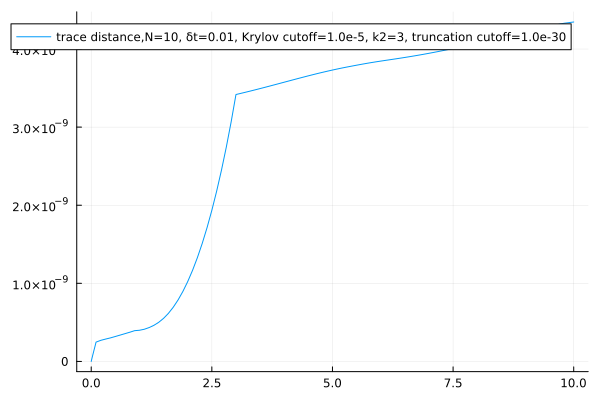

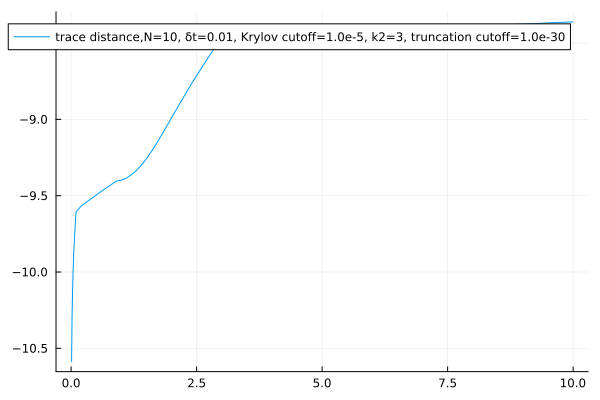

In [47]:
other_norms=false
save_bool = false
error_propagation2(corr,times1,times2,H_single,δt1,δt2,Ci,N,Krylov_cutoff,k2,tdvp_cutoff,other_norms,save_bool)


┌ Info: Saved animation to C:\Users\david\Purified-evolution-various-julia-scripts-Latest\entanglement_entropy_anim,T=10,model=3.gif
└ @ Plots C:\Users\david\.julia\packages\Plots\zzg7i\src\animation.jl:149


Plots.AnimatedGif("C:\\Users\\david\\Purified-evolution-various-julia-scripts-Latest\\entanglement_entropy_anim,T=10,model=3.gif")
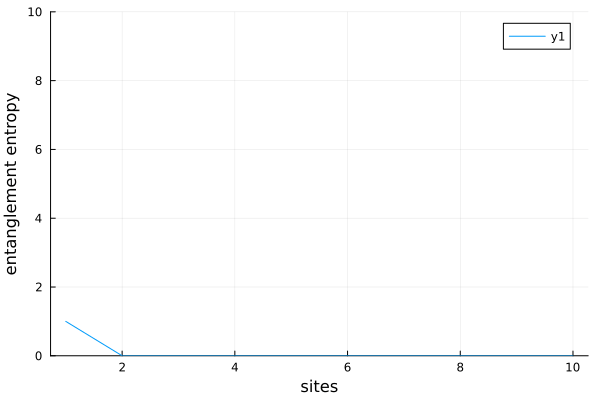

In [48]:
nframe = length(times1) +length(times2)
site_lim = N
SvN_ylim = 10
entanglement_animation(SvN, nframe, site_lim, SvN_ylim,T,model)

In [38]:
U_step2 = exp(-im*δt2*H_single)
C = corr[100]
Cf = U_step2*C*U_step2'

12×12 Matrix{ComplexF64}:
          0.5+0.0im          …    1.4505e-59+1.95576e-59im
     0.499244-0.0274861im       -1.55477e-59-1.87305e-59im
  1.15588e-20-2.78695e-20im     -9.53342e-57-2.584e-57im
  9.78431e-21-2.80727e-20im      9.76453e-57+1.97735e-57im
 -2.48444e-21-1.94494e-21im      9.96622e-41-3.85503e-39im
 -2.57403e-21-1.79248e-21im  …  -1.12377e-40-3.85309e-39im
  1.59172e-22-1.63653e-22im      1.91933e-41-5.70831e-42im
  1.55064e-22-2.09816e-22im      3.19706e-40-5.27988e-43im
 -4.02578e-41-3.98485e-41im     -1.38819e-60-1.24859e-60im
  -5.2328e-41-3.87744e-41im     -3.37241e-62-7.97983e-59im
   1.4913e-59-1.49724e-59im  …   2.95371e-87-5.1452e-79im
   1.4505e-59-1.95576e-59im      2.98328e-77+6.74161e-95im

In [40]:

ψf = tdvp(H, -im * δt2,ψe; time_step = -im * δt2, cutoff = tdvp_cutoff,
    outputlevel=1, normalize=false, (observer!)=obs)


After sweep 1: maxlinkdim=8 maxerr=3.27E-33 current_time=0.0 - 0.01im time=0.056


MPS
[1] ((dim=2|id=458|"Fermion,Site,n=1"), (dim=2|id=224|"Link,n=1"))
[2] ((dim=2|id=128|"Fermion,Site,n=2"), (dim=2|id=77|"Link,l=2"), (dim=2|id=224|"Link,n=1"))
[3] ((dim=2|id=273|"Fermion,Site,n=3"), (dim=4|id=961|"Link,n=1"), (dim=2|id=77|"Link,l=2"))
[4] ((dim=2|id=575|"Fermion,Site,n=4"), (dim=5|id=342|"Link,l=4"), (dim=4|id=961|"Link,n=1"))
[5] ((dim=2|id=502|"Fermion,Site,n=5"), (dim=8|id=277|"Link,n=1"), (dim=5|id=342|"Link,l=4"))
[6] ((dim=2|id=215|"Fermion,Site,n=6"), (dim=4|id=723|"Link,l=6"), (dim=8|id=277|"Link,n=1"))
[7] ((dim=2|id=938|"Fermion,Site,n=7"), (dim=2|id=572|"Link,n=1"), (dim=4|id=723|"Link,l=6"))
[8] ((dim=2|id=808|"Fermion,Site,n=8"), (dim=1|id=516|"Link,l=8"), (dim=2|id=572|"Link,n=1"))
[9] ((dim=2|id=826|"Fermion,Site,n=9"), (dim=1|id=639|"Link,n=1"), (dim=1|id=516|"Link,l=8"))
[10] ((dim=2|id=765|"Fermion,Site,n=10"), (dim=1|id=840|"Link,l=10"), (dim=1|id=639|"Link,n=1"))
[11] ((dim=2|id=461|"Fermion,Site,n=11"), (dim=1|id=660|"Link,n=1"), (dim=1|id=840

In [43]:
opnorm(corr[101] - Cf)

6.888400985196601e-11

1×10 Matrix{Float64}:
 3.07725e-16  1.66582e-18  -6.44109e-17  …  1.04843e-16  -1.71387e-16

In [2]:

"""

What to do next:

-We need to work out whether the relative magnitudes of the Krylov states matter, i.e. do we include the delta t?

-The norm of ρ_n is falling, I think these two errors are connected as they both breakdown at the same time.
-I think I should have error checks for various properties of all the objects, i.e. the norm of ρ_n etc.

-Once the projector is diagonalised, the spectra are either 0 or 1, but numerically they deviate from this by an order of
~1e-14. Is there a way of recovering Vp from the diagonal matrix after the values have been rounded?

-The stochastic enrichment method is much more efficient and seems quite straight forward to implement.

-In the paper, they only use k=3 (two Krylov states) to avoid the high bond dimensions of higher order Krylov states.

-Ask on the discourse page if 1TDVP is implemented as this could be another option.



"""
     

"\nWhat to do next:\n\n-We need to work out whether the relative magnitudes of the Krylov states matter, i.e. do we include the delta t?\n\n-The norm of ρ_n is falling, I think these two errors are connected as they both breakdown at the same time.\n-I think I should have error" ⋯ 344 bytes ⋯ " more efficient and seems quite straight forward to implement.\n\n-In the paper, they only use k=3 (two Krylov states) to avoid the high bond dimensions of higher order Krylov states.\n\n-Ask on the discourse page if 1TDVP is implemented as this could be another option.\n\n\n\n"

In [ ]:
"""
Potential efficiency improvements:

-Always sweeping towards the centre will prevent Projectors having an unnecessarily large dimension.

-At the end of the enrichment, the enriched state is almost canonical apart from the first sight which carries this 
extra k factor. Does TDVP need an orthogonal centre at N? If not, we may be able to avoid orthogonalization?

-    In most cases, abs_maxdim will be very high. We don't want to use this. However, if 
    for the other option we use the sum of all the linkdimensions (for n-1) of the Krylov states, 
    It won't be in canonical form so many of the dimensions will actually correspond to the same dimension. 
    Again, this isn't a huge problem because it will still likely be much less than abs_maxdim. I'm not sure how 
    this can be prevented, so I will just use the sum.
    
- Question: Does the kth Krylov state always contain within it the dimensions of the lower order Krylov states?
 This would solve the problem stated just about and would be more efficient.


-For 1TDVP, they found that for k=5 the creation of the Krylov states and the enrichment step were subleading to the TDVP step, but this isn't
what I have at the moment. 2TDVP is slower than 1TDVP but more accurate, so we don't know if these steps should be subleading to TDVP or not, but 
there's definitely ways of increasing the efficiency of these steps.


-There's a more efficient but less accurate way to apply H to ψ, by using the variational approach that's used in TDVP itself. 


-In the paper, they say to use τ=δt but I'm not sure about this as for small delta t, these states won't be that different (think about this more).


-The bottleneck is creating the Krylov states, see if you can make the function more efficient (Vectorise?). 

-During the enrichment, there will be sites that are aleady max rank, i.e close to the first site. Instead of SvDing through
these sights manually, we could use orthogonalize to go between sites that can be enriched. I.e. say we have just enriched
site k, and the next site that can be enriched is site k-n. Instead of SvDing the n states between these two, we could use 
orthogonalize(ψ,k-n) to move to this sight.
"""